In [1]:
#some code for checking gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
import tqdm
import pandas as pd
import time, warnings
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
from PIL import Image
from sklearn.model_selection import KFold
import keras_tuner
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.trial import Trial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import random
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
)


In [6]:

#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/processed_data.csv')
    folds = {}
    for class_label in range(1, 11):
        class_folder_path = os.path.join(root_folder, f"fold{class_label}")
        image_data = []
        all_labels = []
        if not os.path.exists(class_folder_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(class_folder_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(class_folder_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (36, 320):
                      continue
                    image_array = normalize(image_array)
                    reshape_size = image_array.shape + (1,)
                    image_array = image_array.reshape(reshape_size)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels - 1, num_classes=10)
        folds[f"fold{class_label}"] = [image_data, all_labels]
    return folds


root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/melspec"
data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
print(input_shape)

100%|██████████| 837/837 [00:13<00:00, 61.02it/s] 

(873, 36, 320, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/30
62/62 [==============================] - 37s 375ms/step - loss: 3.9927 - accuracy: 0.1086 - val_loss: 2.3261 - val_accuracy: 0.1123
Epoch 2/30
62/62 [==============================] - 19s 309ms/step - loss: 2.2865 - accuracy: 0.1206 - val_loss: 2.3226 - val_accuracy: 0.1203
Epoch 3/30
62/62 [==============================] - 19s 304ms/step - loss: 2.2583 - accuracy: 0.1455 - val_loss: 2.8709 - val_accuracy: 0.1798
Epoch 4/30
62/62 [==============================] - 19s 309ms/step - loss: 2.1546 - accuracy: 0.1983 - val_loss: 2.1961 - val_accuracy: 0.1821
Epoch 5/30
62/62 [==============================] - 19s 311ms/step - loss: 1.9989 - accuracy: 0.2658 - val_loss: 2.3382 - val_accuracy: 0.1821
Epoch 6/30
62/62 [==============================] - 19s 308ms/step - loss: 1.7752 - accuracy: 0.3507 - val_loss: 2.3301 - val_accuracy: 0.3436
Epoch 7/30
62/62 [==============================] - 19s 311ms/step - loss: 1.4095 - accuracy: 0.5104 - val_

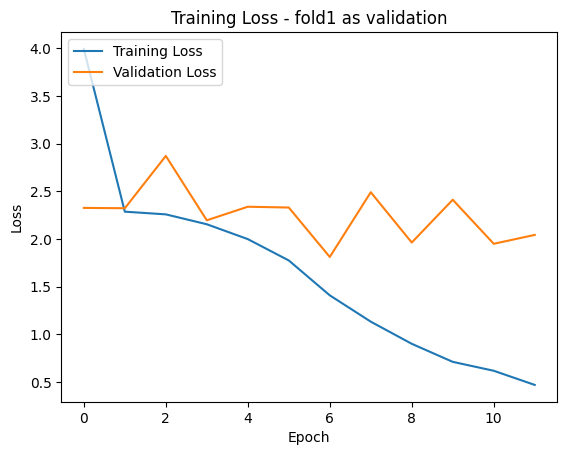

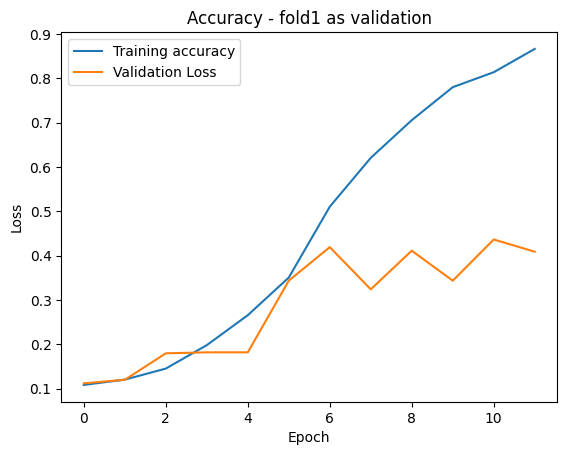

 10%|█         | 1/10 [04:11<37:45, 251.77s/it]

Training using fold2 as validation
Epoch 1/30
62/62 [==============================] - 24s 364ms/step - loss: 4.4603 - accuracy: 0.1132 - val_loss: 2.3088 - val_accuracy: 0.1126
Epoch 2/30
62/62 [==============================] - 19s 306ms/step - loss: 2.2856 - accuracy: 0.1152 - val_loss: 2.2914 - val_accuracy: 0.1126
Epoch 3/30
62/62 [==============================] - 19s 306ms/step - loss: 2.2987 - accuracy: 0.1100 - val_loss: 2.3482 - val_accuracy: 0.1126
Epoch 4/30
62/62 [==============================] - 19s 303ms/step - loss: 2.3001 - accuracy: 0.1133 - val_loss: 2.2818 - val_accuracy: 0.1351
Epoch 5/30
62/62 [==============================] - 19s 306ms/step - loss: 2.2990 - accuracy: 0.1096 - val_loss: 2.3782 - val_accuracy: 0.1092
Epoch 6/30
62/62 [==============================] - 19s 303ms/step - loss: 2.2946 - accuracy: 0.1145 - val_loss: 2.2807 - val_accuracy: 0.1126
Epoch 7/30
62/62 [==============================] - 19s 305ms/step - loss: 2.2915 - accuracy: 0.1085 - val_

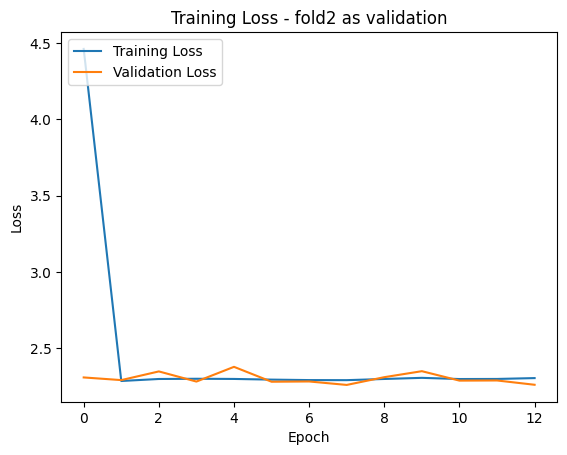

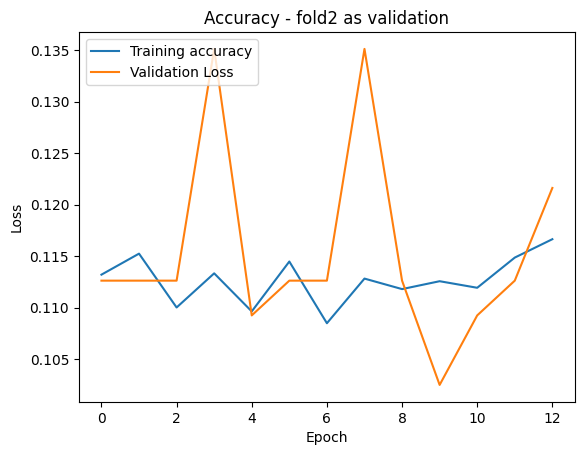

 20%|██        | 2/10 [08:24<33:40, 252.50s/it]

Training using fold3 as validation
Epoch 1/30
61/61 [==============================] - 24s 374ms/step - loss: 4.2806 - accuracy: 0.1160 - val_loss: 2.4876 - val_accuracy: 0.0951
Epoch 2/30
61/61 [==============================] - 19s 313ms/step - loss: 2.2864 - accuracy: 0.1133 - val_loss: 2.3353 - val_accuracy: 0.1081
Epoch 3/30
61/61 [==============================] - 19s 312ms/step - loss: 2.2933 - accuracy: 0.1137 - val_loss: 2.3413 - val_accuracy: 0.1286
Epoch 4/30
61/61 [==============================] - 19s 310ms/step - loss: 2.2782 - accuracy: 0.1380 - val_loss: 2.2962 - val_accuracy: 0.1135
Epoch 5/30
61/61 [==============================] - 19s 314ms/step - loss: 2.2343 - accuracy: 0.1463 - val_loss: 2.2686 - val_accuracy: 0.1946
Epoch 6/30
61/61 [==============================] - 19s 314ms/step - loss: 2.1673 - accuracy: 0.1745 - val_loss: 2.2741 - val_accuracy: 0.1330
Epoch 7/30
61/61 [==============================] - 19s 310ms/step - loss: 2.0553 - accuracy: 0.2309 - val_

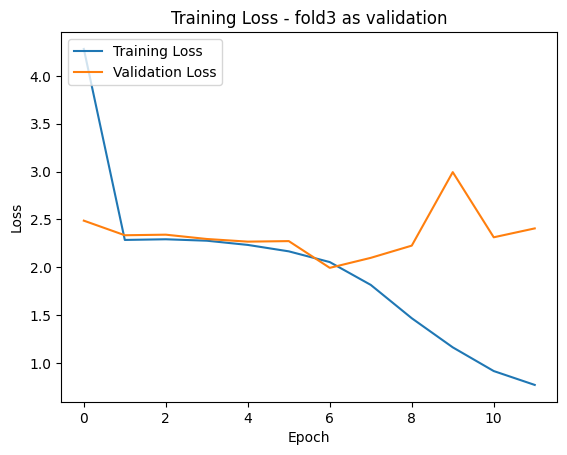

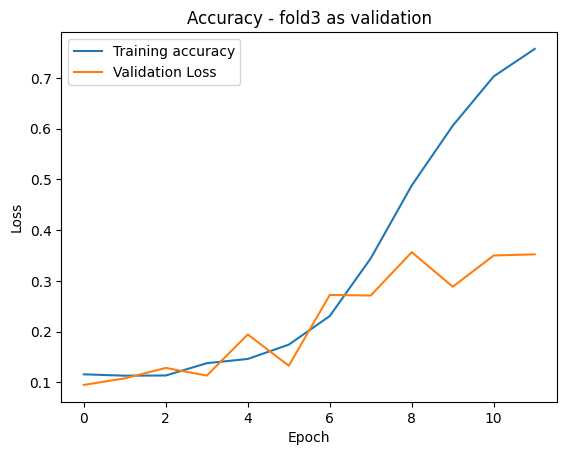

 30%|███       | 3/10 [12:20<28:34, 244.94s/it]

Training using fold4 as validation
Epoch 1/30
61/61 [==============================] - 23s 354ms/step - loss: 3.5133 - accuracy: 0.1223 - val_loss: 2.3098 - val_accuracy: 0.1010
Epoch 2/30
61/61 [==============================] - 19s 307ms/step - loss: 2.2909 - accuracy: 0.1118 - val_loss: 2.3368 - val_accuracy: 0.1010
Epoch 3/30
61/61 [==============================] - 19s 307ms/step - loss: 2.2972 - accuracy: 0.1100 - val_loss: 2.3812 - val_accuracy: 0.1010
Epoch 4/30
61/61 [==============================] - 19s 307ms/step - loss: 2.3002 - accuracy: 0.1125 - val_loss: 2.3079 - val_accuracy: 0.1081
Epoch 5/30
61/61 [==============================] - 19s 304ms/step - loss: 2.2951 - accuracy: 0.1041 - val_loss: 2.2973 - val_accuracy: 0.1010
Epoch 6/30
61/61 [==============================] - 19s 304ms/step - loss: 2.2896 - accuracy: 0.1156 - val_loss: 2.2954 - val_accuracy: 0.1010
Epoch 7/30
61/61 [==============================] - 19s 306ms/step - loss: 2.2981 - accuracy: 0.1117 - val_

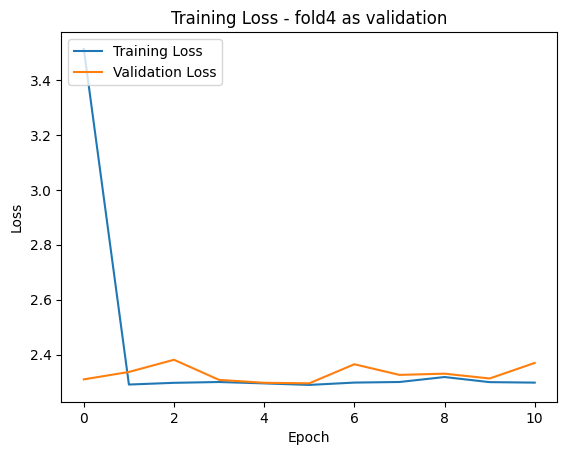

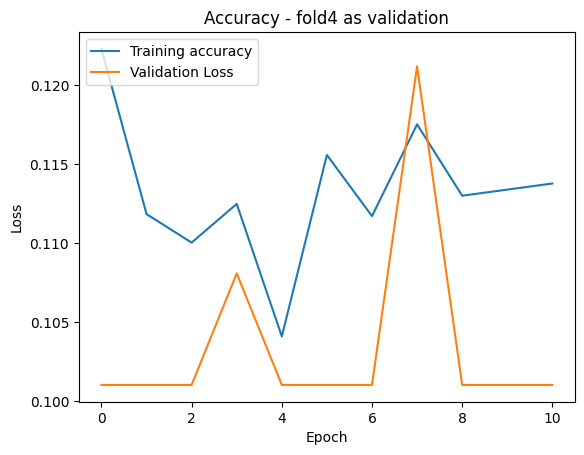

 40%|████      | 4/10 [15:52<23:11, 231.93s/it]

Training using fold5 as validation
Epoch 1/30
61/61 [==============================] - 23s 363ms/step - loss: 5.0332 - accuracy: 0.1148 - val_loss: 2.3938 - val_accuracy: 0.1080
Epoch 2/30
61/61 [==============================] - 19s 307ms/step - loss: 2.2809 - accuracy: 0.1102 - val_loss: 2.3333 - val_accuracy: 0.1070
Epoch 3/30
61/61 [==============================] - 19s 310ms/step - loss: 2.2852 - accuracy: 0.1093 - val_loss: 2.3291 - val_accuracy: 0.1059
Epoch 4/30
61/61 [==============================] - 19s 306ms/step - loss: 2.2775 - accuracy: 0.1159 - val_loss: 2.3883 - val_accuracy: 0.1102
Epoch 5/30
61/61 [==============================] - 19s 306ms/step - loss: 2.2917 - accuracy: 0.1162 - val_loss: 2.3385 - val_accuracy: 0.1070
Epoch 6/30
61/61 [==============================] - 19s 310ms/step - loss: 2.2922 - accuracy: 0.1129 - val_loss: 2.3407 - val_accuracy: 0.1070
Epoch 7/30
61/61 [==============================] - 19s 310ms/step - loss: 2.2842 - accuracy: 0.1146 - val_

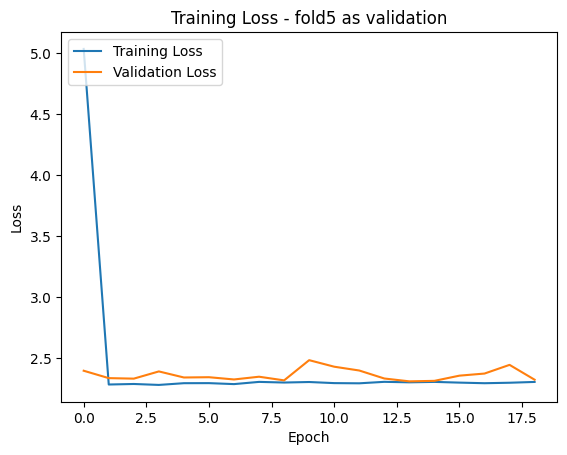

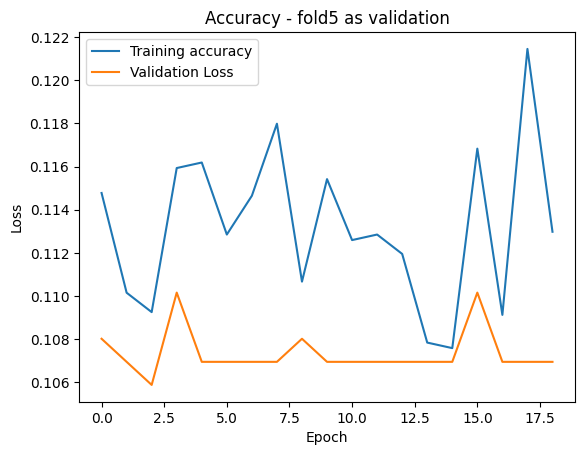

 50%|█████     | 5/10 [21:57<23:18, 279.69s/it]

Training using fold6 as validation
Epoch 1/30
62/62 [==============================] - 23s 356ms/step - loss: 4.2442 - accuracy: 0.1264 - val_loss: 7.1595 - val_accuracy: 0.1300
Epoch 2/30
62/62 [==============================] - 19s 312ms/step - loss: 2.2837 - accuracy: 0.1171 - val_loss: 4.5701 - val_accuracy: 0.1300
Epoch 3/30
62/62 [==============================] - 19s 311ms/step - loss: 2.2858 - accuracy: 0.1183 - val_loss: 2.2523 - val_accuracy: 0.1324
Epoch 4/30
62/62 [==============================] - 19s 308ms/step - loss: 2.2993 - accuracy: 0.1129 - val_loss: 2.2752 - val_accuracy: 0.1495
Epoch 5/30
62/62 [==============================] - 19s 306ms/step - loss: 2.3052 - accuracy: 0.1102 - val_loss: 2.3141 - val_accuracy: 0.1652
Epoch 6/30
62/62 [==============================] - 19s 309ms/step - loss: 2.2646 - accuracy: 0.1376 - val_loss: 6.3190 - val_accuracy: 0.1300
Epoch 7/30
62/62 [==============================] - 19s 310ms/step - loss: 2.2919 - accuracy: 0.1311 - val_

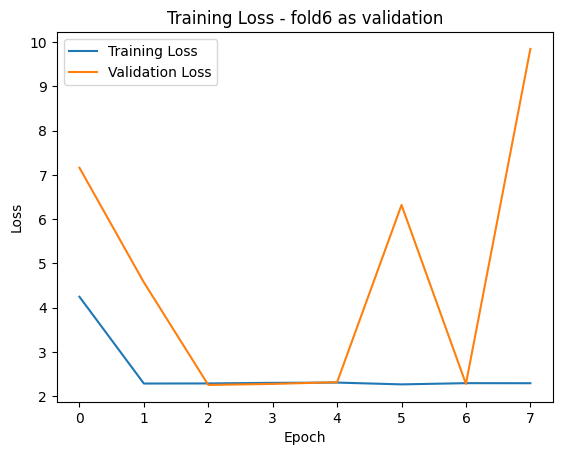

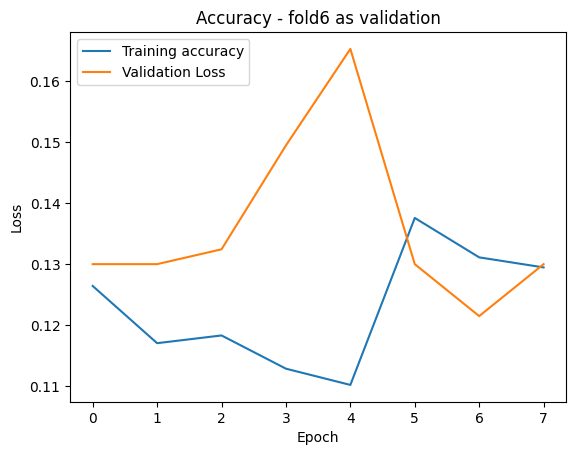

 60%|██████    | 6/10 [24:37<15:56, 239.23s/it]

Training using fold7 as validation
Epoch 1/30
62/62 [==============================] - 23s 350ms/step - loss: 4.3207 - accuracy: 0.1118 - val_loss: 2.6740 - val_accuracy: 0.1193
Epoch 2/30
62/62 [==============================] - 19s 313ms/step - loss: 2.2877 - accuracy: 0.1139 - val_loss: 2.4166 - val_accuracy: 0.1265
Epoch 3/30
62/62 [==============================] - 19s 308ms/step - loss: 2.2797 - accuracy: 0.1186 - val_loss: 2.4998 - val_accuracy: 0.1265
Epoch 4/30
62/62 [==============================] - 19s 311ms/step - loss: 2.2969 - accuracy: 0.1177 - val_loss: 2.6542 - val_accuracy: 0.1265
Epoch 5/30
62/62 [==============================] - 19s 306ms/step - loss: 2.2893 - accuracy: 0.1106 - val_loss: 2.5805 - val_accuracy: 0.1134
Epoch 6/30
62/62 [==============================] - 19s 311ms/step - loss: 2.3014 - accuracy: 0.1066 - val_loss: 2.6114 - val_accuracy: 0.1265
Epoch 7/30
27/27 [==============================] - 1s 23ms/step - loss: 3.2070 - accuracy: 0.1265
Validati

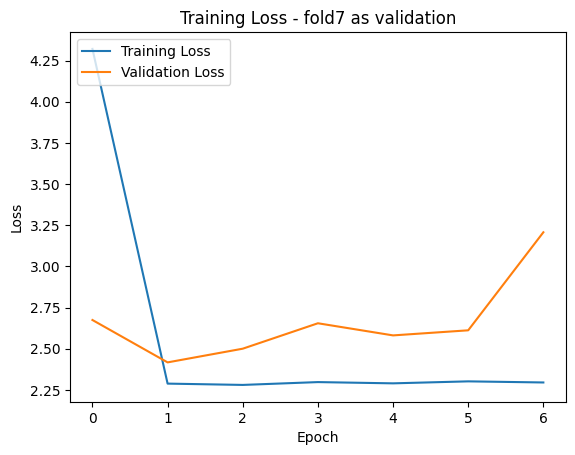

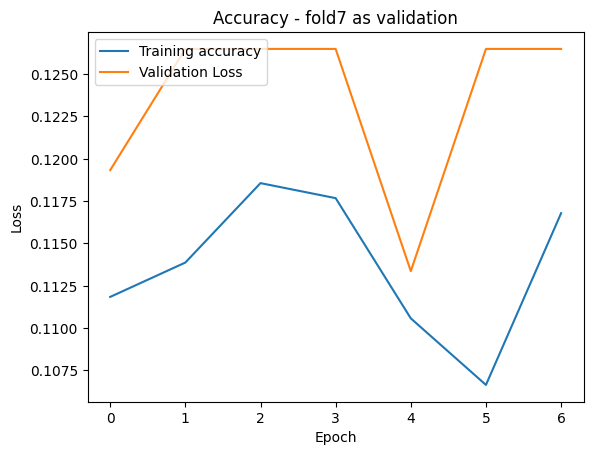

 70%|███████   | 7/10 [26:59<10:22, 207.36s/it]

Training using fold8 as validation
Epoch 1/30
62/62 [==============================] - 23s 355ms/step - loss: 4.8908 - accuracy: 0.1119 - val_loss: 2.4977 - val_accuracy: 0.1252
Epoch 2/30
62/62 [==============================] - 19s 313ms/step - loss: 2.2993 - accuracy: 0.1142 - val_loss: 2.3361 - val_accuracy: 0.1252
Epoch 3/30
62/62 [==============================] - 19s 313ms/step - loss: 2.2821 - accuracy: 0.1166 - val_loss: 2.3249 - val_accuracy: 0.1477
Epoch 4/30
62/62 [==============================] - 19s 309ms/step - loss: 2.2877 - accuracy: 0.1142 - val_loss: 2.6294 - val_accuracy: 0.1252
Epoch 5/30
62/62 [==============================] - 19s 307ms/step - loss: 2.3046 - accuracy: 0.1152 - val_loss: 2.4933 - val_accuracy: 0.1001
Epoch 6/30
62/62 [==============================] - 19s 305ms/step - loss: 2.3114 - accuracy: 0.1112 - val_loss: 2.3468 - val_accuracy: 0.1252
Epoch 7/30
62/62 [==============================] - 19s 310ms/step - loss: 2.3057 - accuracy: 0.1167 - val_

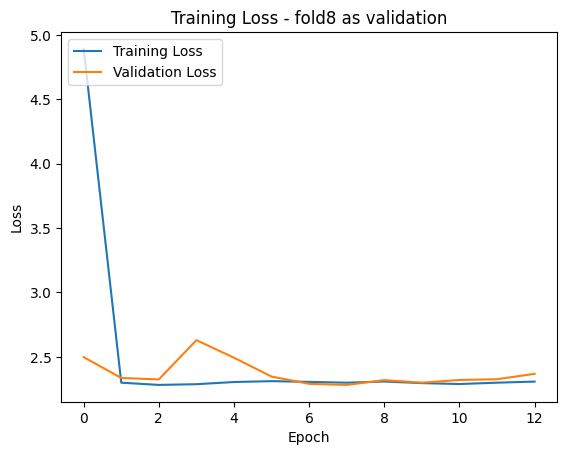

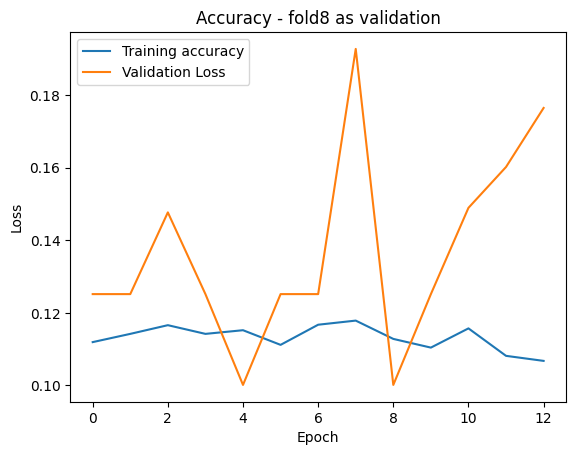

 80%|████████  | 8/10 [31:25<07:32, 226.03s/it]

Training using fold9 as validation
Epoch 1/30
62/62 [==============================] - 24s 358ms/step - loss: 4.8041 - accuracy: 0.1104 - val_loss: 6.2185 - val_accuracy: 0.0380
Epoch 2/30
62/62 [==============================] - 19s 313ms/step - loss: 2.3000 - accuracy: 0.1158 - val_loss: 4.0079 - val_accuracy: 0.0441
Epoch 3/30
62/62 [==============================] - 19s 309ms/step - loss: 2.2909 - accuracy: 0.1119 - val_loss: 2.4724 - val_accuracy: 0.1042
Epoch 4/30
62/62 [==============================] - 19s 305ms/step - loss: 2.2774 - accuracy: 0.1179 - val_loss: 2.2469 - val_accuracy: 0.1189
Epoch 5/30
62/62 [==============================] - 19s 309ms/step - loss: 2.2905 - accuracy: 0.1177 - val_loss: 2.3010 - val_accuracy: 0.0895
Epoch 6/30
62/62 [==============================] - 19s 306ms/step - loss: 2.2739 - accuracy: 0.1305 - val_loss: 2.2670 - val_accuracy: 0.1262
Epoch 7/30
62/62 [==============================] - 19s 310ms/step - loss: 2.2515 - accuracy: 0.1316 - val_

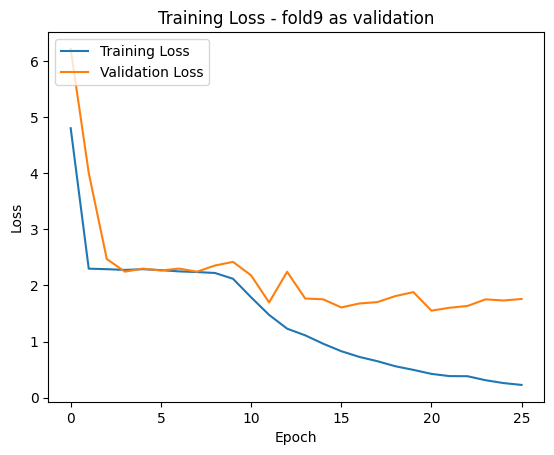

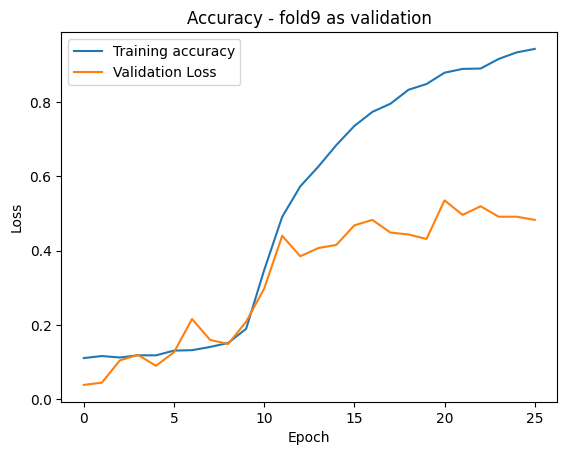

 90%|█████████ | 9/10 [40:52<05:32, 332.51s/it]

Training using fold10 as validation
Epoch 1/30
62/62 [==============================] - 24s 351ms/step - loss: 4.9526 - accuracy: 0.1177 - val_loss: 2.7336 - val_accuracy: 0.1195
Epoch 2/30
62/62 [==============================] - 19s 312ms/step - loss: 2.2918 - accuracy: 0.1121 - val_loss: 2.6070 - val_accuracy: 0.1195
Epoch 3/30
62/62 [==============================] - 19s 310ms/step - loss: 2.2850 - accuracy: 0.1169 - val_loss: 2.8248 - val_accuracy: 0.1195
Epoch 4/30
62/62 [==============================] - 19s 308ms/step - loss: 2.2919 - accuracy: 0.1083 - val_loss: 2.6894 - val_accuracy: 0.1195
Epoch 5/30
62/62 [==============================] - 19s 311ms/step - loss: 2.2989 - accuracy: 0.1103 - val_loss: 2.6645 - val_accuracy: 0.1195
Epoch 6/30
62/62 [==============================] - 19s 312ms/step - loss: 2.2893 - accuracy: 0.1156 - val_loss: 2.6941 - val_accuracy: 0.1195
Epoch 7/30
27/27 [==============================] - 1s 23ms/step - loss: 2.6482 - accuracy: 0.1195
Validat

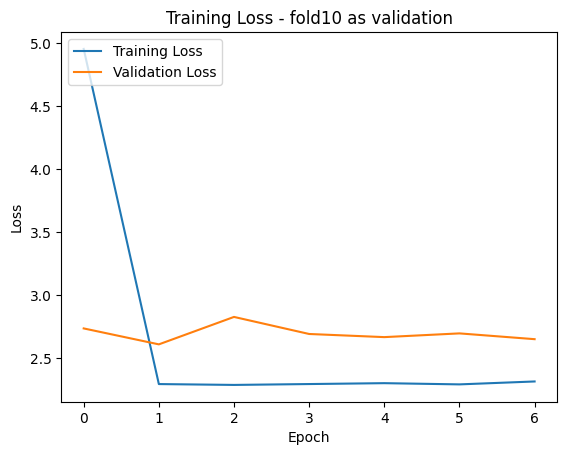

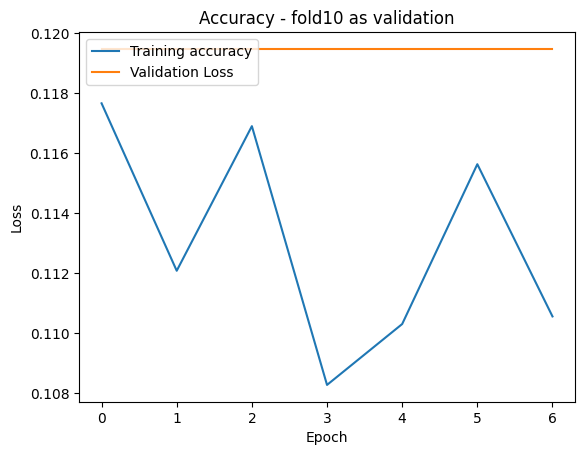

100%|██████████| 10/10 [43:13<00:00, 259.39s/it]

List of scores[0.40893471240997314, 0.12162162363529205, 0.3524324297904968, 0.10101009905338287, 0.10695187002420425, 0.1300121545791626, 0.12649165093898773, 0.1764705926179886, 0.4828431308269501, 0.11947431415319443]
Average accuracy: 0.21262425780296326


In [7]:
tensorflow.keras.backend.clear_session()
metric = 'accuracy' #evaluation metric
#metric = tensorflow.keras.metrics.MeanAveragePrecisionMetric(topn=2)
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 30
batch_size =128
early_stop = 5 # early stoppping after 3 epochs with no improvement of test data

#objective to specify the objective to select the best models, and we use max_trials to specify the number of different models to try.
objective='val_loss'
max_trials = 8 # how many model variations to test?
max_trial_retrys = 3 # how many trials per variation? (same model could perform differently)

# metadata.head(10)
# sns.countplot(metadata, y="class")
#plt.show()

#Building a hypermodel:
# function to build a hypermodel
# takes an argument from which to sample hyperparameters
def build_model(hp):
    model = Sequential()
    input = data['fold1']
    input = input[0]
    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32), (3, 3), input_shape=input.shape[1:]))
    model.add(Activation('tanh'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    for i in range(hp.Int('n_layers', 1, 4)):  # adding variation of layers, this parameter will have a convnet with 2–5 convolutions
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32), (3, 3)))
        model.add(Activation('tanh'))
        # adding dropout
        model.add(tensorflow.keras.layers.Dropout(rate=hp.Float('rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())

    for i in range(hp.Int('n_connections', 1, 4)):
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[128, 256, 512, 1024])))
        model.add(Activation('tanh'))

    model.add(Dense(10))
    model.add(Activation("softmax"))

    model.compile(optimizer=Adam(learning_rate=1e-3), #optimization algorithm used is Adam
                  loss=loss,
                  metrics=[metric])

    return model

#get optimal hyperparameters using
def tuner(X, y, num_epoch, batch_size):
    EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)
    tuner = RandomSearch(build_model, objective=objective, max_trials=max_trials, executions_per_trial=max_trial_retrys, metrics=[metric])
    tuner.search(x=X, y=y, epochs=num_epoch, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStoppingCallback]) #10% is validation data
    best_hyperparameters = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
    return best_hyperparameters

#hyperparameters2 = tuner(X, y, num_epoch, batch_size)
#print(hyperparameters2)

def model_k_cross(hyperparameters, data):
    hp = kt.HyperParameters()
    list_scores = []
    for key, value in hyperparameters.items():
        hp.Fixed(key, value)

    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()
        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        cmodel = build_model(hp)
        cmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)

        history = cmodel.fit(X_train, y_train, epochs=num_epoch, batch_size=batch_size,
                   callbacks=[EarlyStoppingCallback], validation_data=(X_val, y_val))

        # Evaluation
        scores = cmodel.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])


        # Plot training history - loss
        print(history.history.keys())
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation Loss'], loc='upper left')
        plt.show()


    average_acc = sum(list_scores) / len(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc}')




#creating custom hyperparameters to inspect model performance,inspired by the network we found on kaggle
custom_hyperparameters = {
        'input_units': 224,
        'n_layers': 2,
        'conv_0_units': 64,
        'rate': 0.2,
        'n_connections': 1,
        'n_nodes': 1012,
        'conv_1_units': 128,
    }

model_k_cross(custom_hyperparameters, data)
#model(best_hyperparameters_overall)
